# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you): 
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

+ To write a blog entry explaining in your words how does attention work. You can do it in your favourite blog site. If you do not have a favourite blog site, you can start one here: https://hackmd.io/

You have to report all your work at the end of this notebook.



# Code

In [1]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.
    
    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector
    
    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers
    
    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.
    
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    
    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.
    
    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    
    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    
    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset
    
    :model: Model to be fit
    :X_train, y_train: Train samples and labels 
    :X_test y_test: Test samples and labels 
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """
    
    # Train the model
    history=model.fit(X_train, y_train, 
                      validation_split= 0.1, 
                      epochs=epochs,
                      batch_size=batch_size, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])
    
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    
    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))    
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

In [3]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, encoder_lstm, decoder_lstm, decoder_dense


class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [4]:
# dataset 
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model_attention, encoder_lstm, decoder_lstm, decoder_dense = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/200

18/18 [==============================] - 162s 2s/step - loss: 2.9645 - accuracy: 0.0531 - val_loss: 2.9467 - val_accuracy: 0.0566

Epoch 2/200

18/18 [==============================] - 5s 288ms/step - loss: 2.9452 - accuracy: 0.0564 - val_loss: 2.9431 - val_accuracy: 0.0622

Epoch 3/200

18/18 [==============================] - 5s 290ms/step - loss: 2.9403 - accuracy: 0.0629 - val_loss: 2.9344 - val_accuracy: 0.0693

Epoch 4/200

18/18 [==============================] - 5s 292ms/step - loss: 2.9363 - accuracy: 0.0684 - val_loss: 2.9311 - val_accuracy: 0.0738

Epoch 5/200

18/18 [==============================] - 5s 294ms/step - loss: 2.9301 - accuracy: 0.0729 - val_loss: 2.9249 - val_accuracy: 0.0755

Epoch 6/200

18/18 [==============================] - 5s 286ms/step - loss: 2.9236 - accuracy: 0.0771 - val_loss: 2.9166 - val_accuracy: 0.0817

Epoch 7/200

18/18 [==============================] - 5s 285ms/step - loss: 2.9162 - accuracy: 0.0825 - val_loss: 2.9116 - val_accu

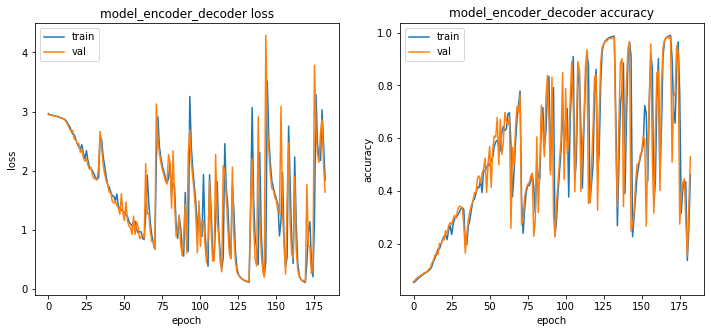

In [ ]:
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=50)

# Bahdanau Attention and Luong General Attention implementation

## Definition

In [5]:
class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()

        # Initialization -------------------------------------------------------
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)       # Single hidden layer network model


    def call(self, query, values):

        query_with_time_axis = tf.expand_dims(query, 1)

        # Score and attention weights ------------------------------------------
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))       # Compute score using Bahnadau's score formula
        attention_weights = tf.nn.softmax(score, axis=1)      # Normalize the score 
        
        # Context vector -------------------------------------------------------
        context_vector = attention_weights * values           # Context vector
        context_vector = tf.reduce_sum(context_vector, axis=1)


        return context_vector, attention_weights

In [6]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()
        
        # Initialization -------------------------------------------------------
        self.W = tf.keras.layers.Dense(units)
        

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # Score and attention weights ------------------------------------------
        score = tf.transpose(tf.matmul(query_with_time_axis, self.W(values_transposed)), perm=[0, 2, 1])
        attention_weights = tf.nn.softmax(score, axis=1)

        # Context vector -------------------------------------------------------
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## Training

In [ ]:
# Build the model using LuongDotAttention --------------------------------------
attention_ld = LuongDotAttention()
model_attention, encoder_lstm_ld, decoder_lstm_ld, decoder_dense_ld = build_attention_model(attention_ld, batch_size, rnn_units)

2022-12-28 13:47:23.614424: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-12-28 13:49:07.410846: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


18/18 [==============================] - 149s 2s/step - loss: 2.9641 - accuracy: 0.0538 - val_loss: 2.9466 - val_accuracy: 0.0535
Epoch 2/200
18/18 [==============================] - 5s 285ms/step - loss: 2.9455 - accuracy: 0.0556 - val_loss: 2.9431 - val_accuracy: 0.0704
Epoch 3/200
18/18 [==============================] - 5s 282ms/step - loss: 2.9440 - accuracy: 0.0621 - val_loss: 2.9463 - val_accuracy: 0.0625
Epoch 4/200
18/18 [==============================] - 5s 277ms/step - loss: 2.9431 - accuracy: 0.0635 - val_loss: 2.9413 - val_accuracy: 0.0644
Epoch 5/200
18/18 [==============================] - 5s 276ms/step - loss: 2.9358 - accuracy: 0.0720 - val_loss: 2.9295 - val_accuracy: 0.0811
Epoch 6/200
18/18 [==============================] - 5s 283ms/step - loss: 2.9238 - accuracy: 0.0791 - val_loss: 2.9191 - val_accuracy: 0.0835
Epoch 7/200
18/18 [==============================] - 5s 280ms/step - loss: 2.9139 - accuracy: 0.0837 - val_loss: 2.9104 - val_accuracy: 0.0891
Epoch 8/200


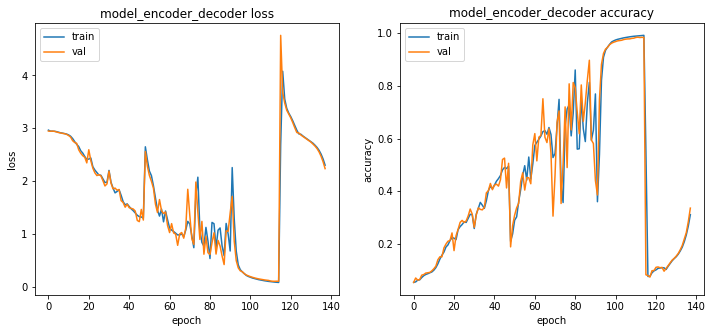

In [ ]:
# Train the model using LuongDotAttention --------------------------------------
train_test(model_attention, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=25)

In [7]:
# Build the model using BahdanauAttention --------------------------------------
attention_b = BahdanauAttention(rnn_units)
model_attention, encoder_lstm_b, decoder_lstm_b, decoder_dense_b = build_attention_model(attention_b, batch_size, rnn_units)

2022-12-29 10:04:33.789694: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-12-29 10:06:25.952115: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


18/18 [==============================] - 169s 3s/step - loss: 2.9649 - accuracy: 0.0529 - val_loss: 2.9462 - val_accuracy: 0.0540
Epoch 2/200
18/18 [==============================] - 14s 762ms/step - loss: 2.9452 - accuracy: 0.0573 - val_loss: 2.9448 - val_accuracy: 0.0635
Epoch 3/200
18/18 [==============================] - 14s 774ms/step - loss: 2.9427 - accuracy: 0.0616 - val_loss: 2.9393 - val_accuracy: 0.0688
Epoch 4/200
18/18 [==============================] - 14s 772ms/step - loss: 2.9358 - accuracy: 0.0692 - val_loss: 2.9328 - val_accuracy: 0.0708
Epoch 5/200
18/18 [==============================] - 14s 764ms/step - loss: 2.9289 - accuracy: 0.0744 - val_loss: 2.9261 - val_accuracy: 0.0778
Epoch 6/200
18/18 [==============================] - 14s 769ms/step - loss: 2.9199 - accuracy: 0.0793 - val_loss: 2.9196 - val_accuracy: 0.0817
Epoch 7/200
18/18 [==============================] - 14s 768ms/step - loss: 2.9116 - accuracy: 0.0837 - val_loss: 2.9110 - val_accuracy: 0.0850
Epoch 

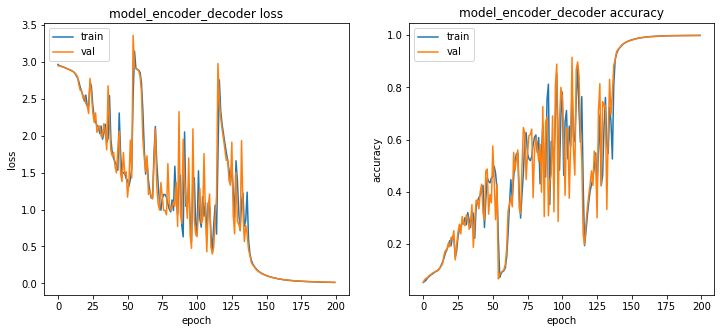

In [ ]:
# Train the model using BahdanauAttention --------------------------------------
train_test(model_attention, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=40)

In [16]:
# Build the model using LuongGeneralAttention ----------------------------------
attention_lg = LuongGeneralAttention(rnn_units)
model_attention, encoder_lstm_lg, decoder_lstm_lg, decoder_dense_lg = build_attention_model(attention_lg, batch_size, rnn_units)

Epoch 1/200
18/18 [==============================] - 208s 3s/step - loss: 2.9666 - accuracy: 0.0547 - val_loss: 2.9465 - val_accuracy: 0.0522
Epoch 2/200
18/18 [==============================] - 13s 701ms/step - loss: 2.9444 - accuracy: 0.0571 - val_loss: 2.9416 - val_accuracy: 0.0697
Epoch 3/200
18/18 [==============================] - 12s 690ms/step - loss: 2.9393 - accuracy: 0.0660 - val_loss: 2.9345 - val_accuracy: 0.0733
Epoch 4/200
18/18 [==============================] - 12s 687ms/step - loss: 2.9325 - accuracy: 0.0722 - val_loss: 2.9266 - val_accuracy: 0.0756
Epoch 5/200
18/18 [==============================] - 12s 673ms/step - loss: 2.9197 - accuracy: 0.0804 - val_loss: 2.9096 - val_accuracy: 0.0867
Epoch 6/200
18/18 [==============================] - 12s 674ms/step - loss: 2.8966 - accuracy: 0.0931 - val_loss: 2.8812 - val_accuracy: 0.0985
Epoch 7/200
18/18 [==============================] - 12s 690ms/step - loss: 2.8652 - accuracy: 0.1055 - val_loss: 2.8478 - val_accuracy: 0

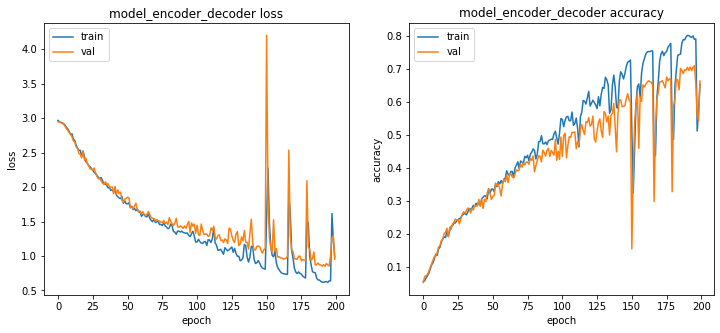

In [ ]:
# Train the model using LuongGeneralAttention ----------------------------------
train_test(model_attention, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=25)

**Consideration regarding the training process of the three models:** for this specific task the training of the models was considerably demanding in terms of computational time. For this reason, not too many experiments were made and the parameters, such as the batch size, the number of epochs and the patience for the early stopping, were not fine tuned for an optimal training. The observations made in the following Comparative section are thus subject to this type of variability and are the result of an average of what has been observed in the outcomes of the tests made. 

# Comparative

**RESULTS:** 

In the following the results of the training of the models using the three different attention mechanisms

*   Model using Luong dot attention


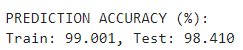

*   Model using Bahdanau attention

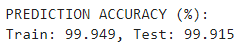

*   Model using Luong general attention

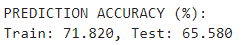

**OBSERVATIONS:**

Clearly, the results of the training are subject to some variability, in order to try and reduce it as much as possible, high values of patience, for the early stopping, were chosen. (25 for the Luong attention and 40 for the Bahdanau attention) The observations made are a conclusion of many experiments and training sessions of the models, not only the last performed, which are the ones presented.

In general, after some experimenting and repeated training of the models, we can observe that


*   The model using Bahdanau attention takes a bit longer to converge to a good enough result (thus the choice for a higher value of the patience parameter)
*   The model using Bahdanau attention seems, on average, to be performing slightly better than the one using Luong dot attention
*   The model using Luong general attention obtains a worse result compared to the other two models, perhaps due to the necessity of a longer training (which was a bit too demanding in terms of computational time for this specific exercise) 
*   The three models result in good weight visualization matrix structures (this will be shown and commented in the following section)


# Weight Visualization

In [12]:
def evaluate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
  # Initialization -------------------------------------------------------------
  attention_plot = np.zeros((n_timesteps_in, n_timesteps_in))
  sequence = one_hot_encode(seq_in,n_features)

  # ENCODER STEP ---------------------------------------------------------------
  encoder_inputs = np.array(sequence).reshape(1,n_timesteps_in,n_features)
  encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)
  encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

  states = [encoder_state_h, encoder_state_c]
  all_outputs = []

  # DECODER STEP ---------------------------------------------------------------
  decoder_input_data = np.zeros((1, 1, n_features))
  decoder_input_data[:, 0, 0] = 1 
  inputs = decoder_input_data
  decoder_outputs = encoder_state_h

  for t in range(n_timesteps_in):
      # Pay attention
      # Create the context vector by applying attention to the outputs.
      context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
      context_vector = tf.expand_dims(context_vector, 1)

      # Concatenate the input + context vectore to find the next decoder's input
      inputs = tf.concat([context_vector, inputs], axis=-1)

      # Storing the attention weights to plot later on
      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[t] = attention_weights.numpy()
      
      # Passing the concatenated vector to the LSTM
      # Run the decoder on one timestep and previous states
      decoder_outputs=tf.expand_dims(decoder_outputs, 1)
      decoder_outputs, encoder_state_h, encoder_state_c = decoder_lstm(inputs, initial_state=states)
      outputs = decoder_dense(decoder_outputs)

      # Use the last hidden state for prediction the output, save the current prediction
      # Predictions will be concatenated later
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)

      # Reinject the outputs as inputs for the next loop iteration as well as update the states
      inputs = outputs
      states = [encoder_state_h, encoder_state_c]

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  seq_out=one_hot_decode(decoder_outputs[0])
  
  return seq_in, seq_out, attention_plot

In [13]:
import matplotlib.ticker as ticker

def plot_attention(attention, sequence, predicted_sequence):
  fig = plt.figure(figsize=(16,16))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  # labels ---------------------------------------------------------------------
  fontdict = {'fontsize': 10}
  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [14]:
def translate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
  seq_in, seq_out, attention_plot = evaluate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention)
  attention_plot = attention_plot[:len(seq_out), :len(seq_in)]
  plot_attention(attention_plot, seq_in, seq_out)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


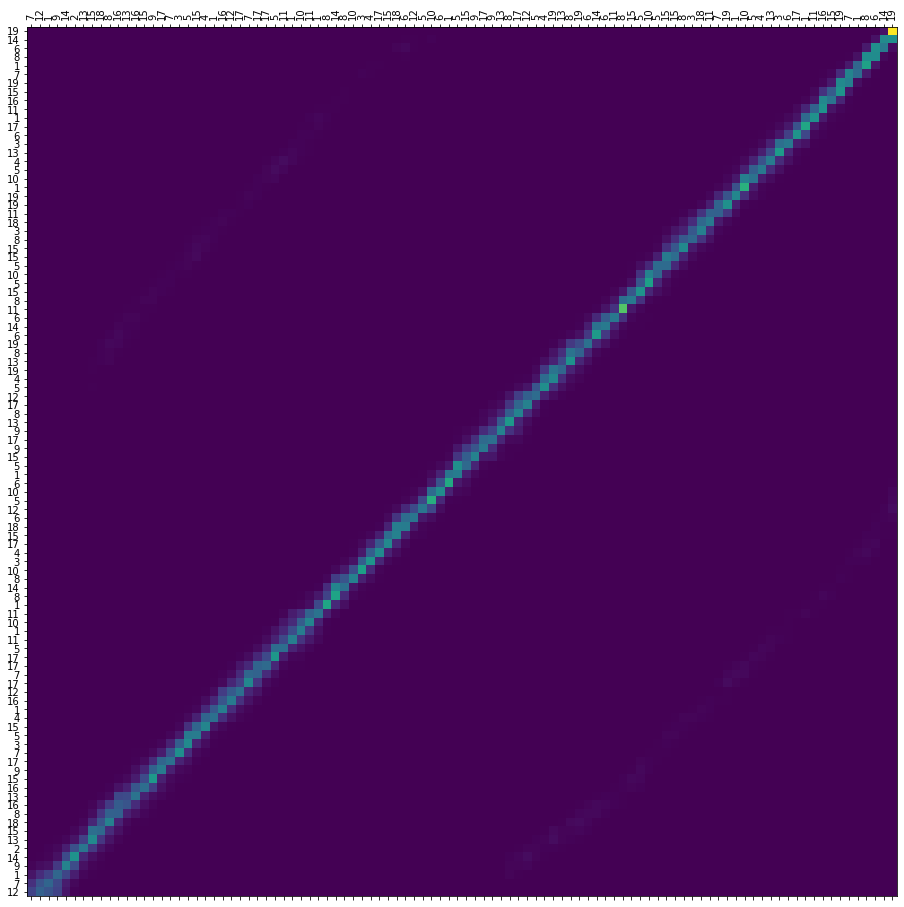

In [ ]:
# Plot the wights of the model using LuongDotAttention -------------------------
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_ld, decoder_lstm_ld, decoder_dense_ld, attention_ld)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


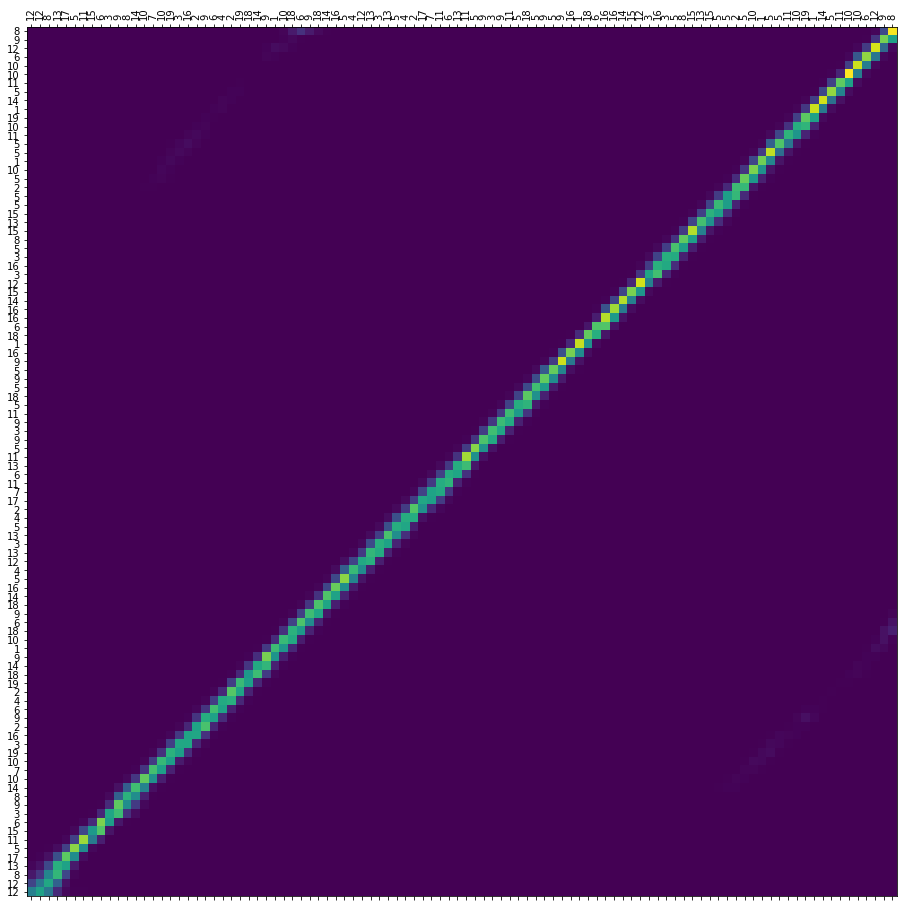

In [ ]:
# Plot the weights of the model using BahdanauAttention ------------------------
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_b, decoder_lstm_b, decoder_dense_b, attention_b)

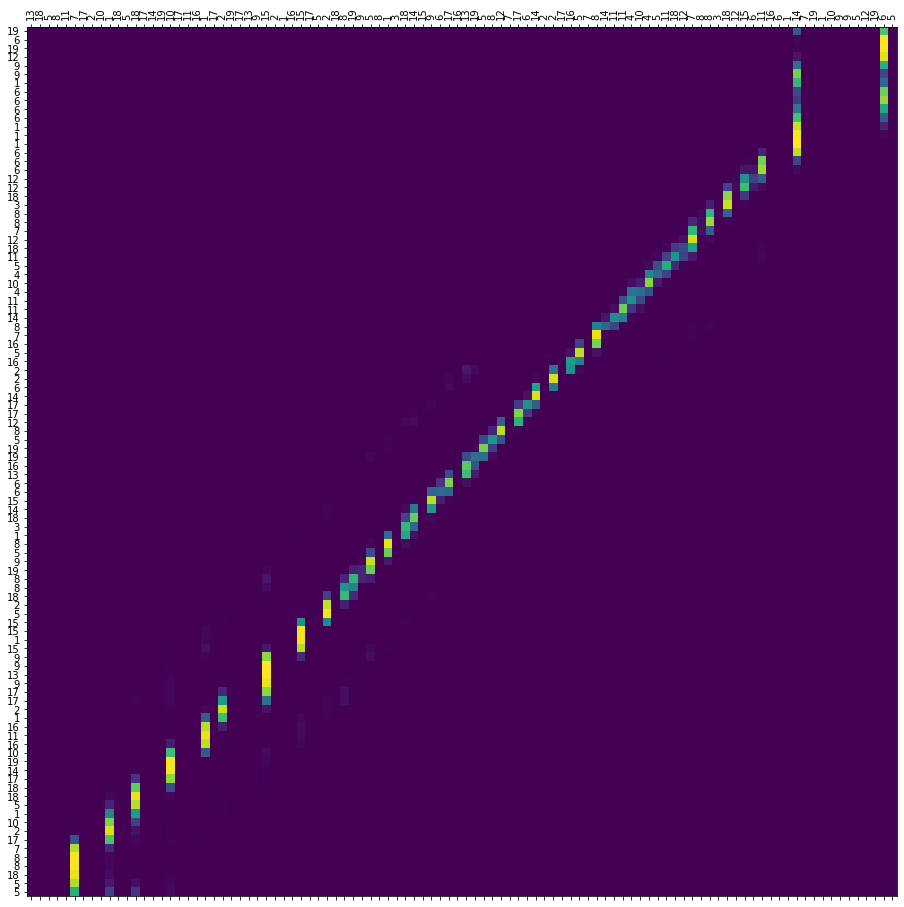

In [ ]:
# Plot the weights of the model using LuongGeneralAttention  -------------------
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_lg, decoder_lstm_lg, decoder_dense_lg, attention_lg)

**OBSERRVATION:** The diagonal appears to be inverted due to the way the axes are ordered. The resulting structure seems to be the desired outcome. In the last experiment, the one using Luong general attention, the matrix appears to be moving towards the same desired structure as well.

# Blog site

Link to the blog post page: https://hackmd.io/@pZpT2t08QVizsgiFR4pbmQ/BkmVpGsOj

# Report

+ Bahdanau Attention and Luong General Attention implementation.
+ Comparative.
+ Weight visualization. 
+ Blog site.

